In [243]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import pickle

In [244]:
df = pd.read_excel('../data/NBAStats.xlsx').set_index('PLAYER')
df = df[df['GP'] >= 10]
df = df[df['MIN'] >= 15]
# Perhaps a poor practice and should remove them in the scraping algorithm
df = df.drop(columns=['TEAM', 'W', 'L', 'GP', 'DREB', 'STL', 'BLK'])
df = df.astype(float)

Removes the team column from the dataframe for now. It may be added back for future analysis but as a string it causes problems for the clustering algorithm. Also dropping players who have played less than 10 games because the sample size is so small.

In [245]:
dfPlayerCol = df.reset_index()

In [246]:
features = list(df.columns)
# Removes the column titles for data processing
x = df.loc[:, features].values
# Good practice to scale the data down based on variance
x = StandardScaler().fit_transform(x) 


Feature refers to the data that you are using in ML model to make predictions. Feature engineering is the process of finding the best features for the model. 

In [247]:
variance_list = []
for n_components in range(2,len(df.columns)):
    # Dimensionality Reduction
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(x)
    variance = sum(pca.explained_variance_ratio_)
    variance_list.append(variance)
    print(f"Variance with {n_components} components: {variance}")


Variance with 2 components: 0.4217496216336926
Variance with 3 components: 0.525269519050481
Variance with 4 components: 0.6238133055938414
Variance with 5 components: 0.6775377205616753
Variance with 6 components: 0.7233685605672607
Variance with 7 components: 0.7572291522573188
Variance with 8 components: 0.7883034029208847
Variance with 9 components: 0.8144664310800444
Variance with 10 components: 0.8390924471938864
Variance with 11 components: 0.8605031742699014
Variance with 12 components: 0.880916543165601
Variance with 13 components: 0.8976536032597844
Variance with 14 components: 0.9135966709042745
Variance with 15 components: 0.9289444899883122
Variance with 16 components: 0.9411267296189452
Variance with 17 components: 0.9522977142605212
Variance with 18 components: 0.96141441778723
Variance with 19 components: 0.9700388047505654
Variance with 20 components: 0.97660374697148
Variance with 21 components: 0.9815326513961358
Variance with 22 components: 0.9857984193789192
Varian

This helps determine how much variance in the dataset is captured as the number of components increases. This will aid in choosing the ideal number of components for dimensionality reduction.

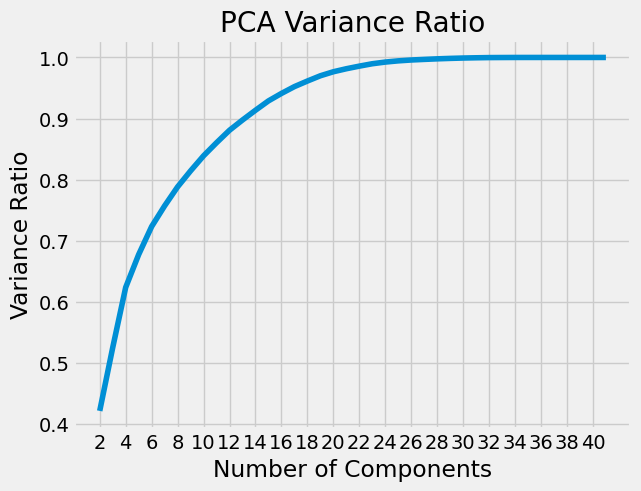

In [248]:
#Useful graph for visualization of ratio changes
plt.style.use('fivethirtyeight')
pca_fig, ax = plt.subplots()
ax.plot(range(2,len(df.columns)), variance_list)
ax.set_xlabel('Number of Components')
ax.set_ylabel('Variance Ratio')
ax.set_xticks(np.arange(2, len(df.columns), 2))
ax.set_title('PCA Variance Ratio')
pca_fig.savefig('../images/PCA_Variance_Ratio.png')

In [249]:
from numpy import diff
diff_variance = diff(variance_list)
print(diff_variance)

[1.03519897e-01 9.85437865e-02 5.37244150e-02 4.58308400e-02
 3.38605917e-02 3.10742507e-02 2.61630282e-02 2.46260161e-02
 2.14107271e-02 2.04133689e-02 1.67370601e-02 1.59430676e-02
 1.53478191e-02 1.21822396e-02 1.11709846e-02 9.11670353e-03
 8.62438696e-03 6.56494222e-03 4.92890442e-03 4.26576798e-03
 3.91869537e-03 2.72966070e-03 1.98634382e-03 1.41192261e-03
 9.83994234e-04 9.02567221e-04 7.37506532e-04 5.89520896e-04
 4.12489411e-04 3.18594867e-04 1.12636640e-04 8.06102399e-05
 1.64423388e-05 4.99467123e-07 8.55290327e-08 6.62923616e-09
 3.28917982e-09 8.27145463e-10 0.00000000e+00]


This calculates the difference between consecutive elements in the variance_list array. Slope calculus, used to determine the "elbow point" in PCA which is where the rate of variance slows down

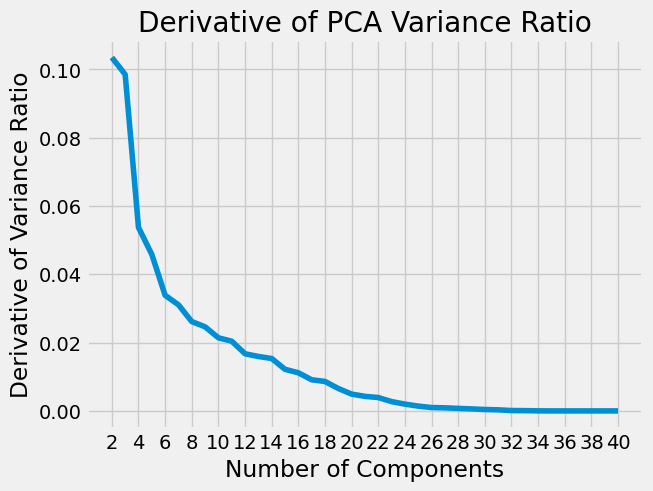

In [250]:
pca_deriv, ax = plt.subplots()
ax.plot(range(2, len(df.columns) - 1), diff_variance)
ax.set_xlabel('Number of Components')
ax.set_ylabel('Derivative of Variance Ratio')
ax.set_xticks(np.arange(2, len(df.columns), 2))
ax.set_title('Derivative of PCA Variance Ratio')
pca_deriv.savefig('../images/PCA_Derivative.png')

Good data should have a high PCA Variance Ratio along with a low Derivative of the Variance Ratio. By using both criteria, you balance data representativeness (high variance ratio) and computational efficiency (low derivative).

In [251]:
n_comp = 16
pca = PCA(n_components=n_comp)

# Reducing the dimensions of the data
components = pca.fit_transform(x)

pca_df = pd.DataFrame(data = components, columns = [f'PC{i}' for i in range(1, n_comp + 1)])

pca_df['PLAYER'] = dfPlayerCol['PLAYER']
pca_df = pca_df[['PLAYER'] + [f'PC{i}' for i in range(1, n_comp + 1)]]
pca_df

print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[0.21295877 0.20879085 0.1035199  0.09854379 0.05372441 0.04583084
 0.03386059 0.03107425 0.02616303 0.02462602 0.02141073 0.02041337
 0.01673706 0.01594307 0.01534782 0.01218224]
0.9411267296189452


In [252]:
x = np.column_stack([pca_df[f'PC{i}'] for i in range(1, n_comp)])

# We want a high silhouette score along with meaningful analysis
silhouette = []

for n_clusters in range(2, 32):
    kmeans = KMeans(n_clusters=n_clusters, random_state = 1)
    cluster_labels = kmeans.fit_predict(x)
    centers = kmeans.cluster_centers_
    score = silhouette_score(x, cluster_labels)
    silhouette.append(score)
    print(f"Silhouette Score with {n_clusters} clusters: {score}")

Silhouette Score with 2 clusters: 0.21520147493050915
Silhouette Score with 3 clusters: 0.18783916780064194
Silhouette Score with 4 clusters: 0.1563258037632914
Silhouette Score with 5 clusters: 0.1343482348877753
Silhouette Score with 6 clusters: 0.11414471966172533
Silhouette Score with 7 clusters: 0.11410171485920781
Silhouette Score with 8 clusters: 0.1130430582307213
Silhouette Score with 9 clusters: 0.10718361513260985
Silhouette Score with 10 clusters: 0.09969270586824723
Silhouette Score with 11 clusters: 0.09968801331226006
Silhouette Score with 12 clusters: 0.09433198104478327
Silhouette Score with 13 clusters: 0.0919673311260912
Silhouette Score with 14 clusters: 0.08515426941483949
Silhouette Score with 15 clusters: 0.07822801199918746
Silhouette Score with 16 clusters: 0.07704211189850814
Silhouette Score with 17 clusters: 0.07636832614079059
Silhouette Score with 18 clusters: 0.07839738415710087
Silhouette Score with 19 clusters: 0.07274601012352078
Silhouette Score with 

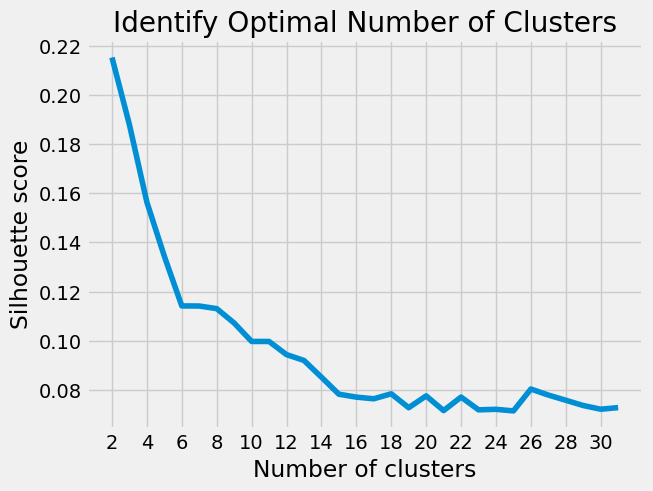

In [253]:
plt.style.use('fivethirtyeight')
silhouette_fig, ax = plt.subplots()
ax.plot(range(2,2 + len(silhouette)), silhouette)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette score')
ax.set_xticks(np.arange(2, 2+len(silhouette), 2))
ax.set_title('Identify Optimal Number of Clusters')
silhouette_fig.savefig('../images/Optimal_Clusters.png')

In [254]:
silhouette_diff = []

for i in range(1, len(silhouette)):
    improvement = 1 - ((1-silhouette[i]) / (1 - silhouette[i - 1]))
    silhouette_diff.append(improvement)
    print(f"for n_cluseter = {i + 2}, improvement = {improvement}") 

for n_cluseter = 3, improvement = -0.03486539061403615
for n_cluseter = 4, improvement = -0.03880187616535413
for n_cluseter = 5, improvement = -0.02604982939332401
for n_cluseter = 6, improvement = -0.023339079339173674
for n_cluseter = 7, improvement = -4.854608136573013e-05
for n_cluseter = 8, improvement = -0.0011950092310182292
for n_cluseter = 9, improvement = -0.006606231737048329
for n_cluseter = 10, improvement = -0.008390201379957052
for n_cluseter = 11, improvement = -5.212171463764292e-06
for n_cluseter = 12, improvement = -0.005949084702495
for n_cluseter = 13, improvement = -0.0026109455884506527
for n_cluseter = 14, improvement = -0.007503101975065318
for n_cluseter = 15, improvement = -0.007570956702417808
for n_cluseter = 16, improvement = -0.0012865438699773968
for n_cluseter = 17, improvement = -0.0007300287113896076
for n_cluseter = 18, improvement = 0.0021968259358541298
for n_cluseter = 19, improvement = -0.006132115877743427
for n_cluseter = 20, improvement = 0.0

C:\conda_tmp\ipykernel_26644\1289475222.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


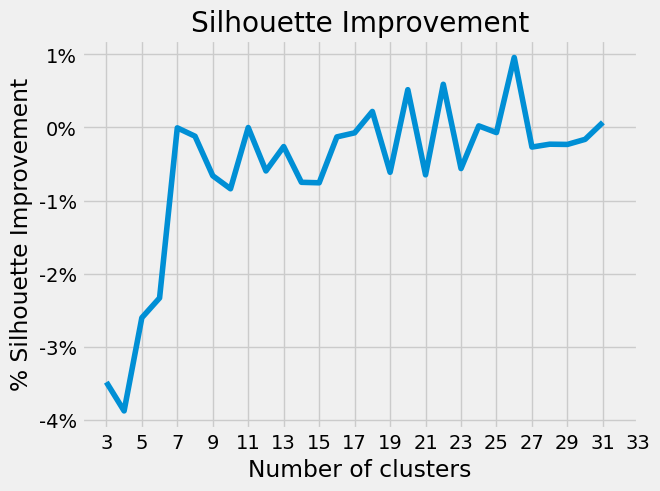

In [255]:
plt.style.use('fivethirtyeight')
silhouette_improvement_fig, ax = plt.subplots()
ax.plot(range(3, 2 + len(silhouette)), silhouette_diff)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('% Silhouette Improvement')
ax.set_xticks(np.arange(3, 4 + len(silhouette), 2))
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.set_title('Silhouette Improvement')
silhouette_fig.savefig('../images/Silhouette_Improvement.png')

In [256]:
kmeans = KMeans(n_clusters = 16, random_state = 1)

kmeans.fit(x)

y_kmeans = kmeans.predict(x)
with open("../models/clusterMode.sav", 'wb') as f:
    pickle.dump(kmeans, f)

In [257]:
df_cluster = pd.DataFrame()

df_cluster['Player'] = dfPlayerCol['PLAYER']
df_cluster['Cluster'] = y_kmeans
df_cluster.head()

,Player,Cluster
0,Anthony Black,1
1,Bennedict Mathurin,12
2,Clint Capela,8
3,De'Aaron Fox,10
4,Jake LaRavia,2


In [258]:
pd.DataFrame.to_excel(df_cluster, '../data/clusteredPlayers.xlsx')